In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from glob import glob
from tqdm import tqdm
import pickle
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

In [2]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
city_3d_model_path = config['data']['city_3d_model']

In [3]:
def print_element(element, indent=""):
    """
    Recursively prints the tag, attributes, and text content of an XML element and its child elements.

    Args:
        element (xml.etree.ElementTree.Element): The XML element to print.
        indent (str): The indentation string to use for nested elements.

    Returns:
        None
    """
    # Print element tag and attributes
    print(f"{indent}Tag: {element.tag}")
    for attribute, value in element.attrib.items():
        print(f"{indent}Attribute: {attribute} = {value}")
    
    # Print element text content, if available
    if element.text and element.text.strip():
        print(f"{indent}Text: {element.text.strip()}")

    # Recursively print child elements
    for child in element:
        print_element(child, indent + "  ")

In [4]:
file_path = city_3d_model_path + 'raw_gml/690_5334.gml'
tree = ET.parse(file_path)
root = tree.getroot()

In [5]:
namespace = {'bldg': 'http://www.opengis.net/citygml/building/1.0',
                 'gen': 'http://www.opengis.net/citygml/generics/1.0',
                 'gml': 'http://www.opengis.net/gml'}

buildings= root.findall('.//bldg:Building', namespace)
building_elem = buildings[0]
print_element(building_elem)


Tag: {http://www.opengis.net/citygml/building/1.0}Building
Attribute: {http://www.opengis.net/gml}id = DEBY_LOD2_4863012
  Tag: {http://www.opengis.net/citygml/1.0}creationDate
  Text: 2018-03-19
  Tag: {http://www.opengis.net/citygml/1.0}externalReference
    Tag: {http://www.opengis.net/citygml/1.0}informationSystem
    Text: http://repository.gdi-de.org/schemas/adv/citygml/fdv/art.htm#_9100
    Tag: {http://www.opengis.net/citygml/1.0}externalObject
      Tag: {http://www.opengis.net/citygml/1.0}name
      Text: DEBYvAAAAABUFQMp
  Tag: {http://www.opengis.net/citygml/generics/1.0}stringAttribute
  Attribute: name = DatenquelleBodenhoehe
    Tag: {http://www.opengis.net/citygml/generics/1.0}value
    Text: 1100
  Tag: {http://www.opengis.net/citygml/generics/1.0}stringAttribute
  Attribute: name = DatenquelleDachhoehe
    Tag: {http://www.opengis.net/citygml/generics/1.0}value
    Text: 1000
  Tag: {http://www.opengis.net/citygml/generics/1.0}stringAttribute
  Attribute: name = Daten

In [6]:
def parse_coordinates(coordinate_string):
    coordinate_list = coordinate_string.split(' ')
    coordinates = [float(c) for c in coordinate_list]
    return coordinatess

In [7]:
def parse_xml(file_name):
    # parse the XML document
    tree = ET.parse(file_name)
    root = tree.getroot()

    # define the namespaces
    namespaces = {'bldg': 'http://www.opengis.net/citygml/building/1.0', 
                  'gml': 'http://www.opengis.net/gml'}

    buildings = []

    # extract the buildings
    for building in root.findall('.//bldg:Building', namespaces):
        surfaces = {'WallSurface': [], 'RoofSurface': [], 'GroundSurface': []}

        # extract the surface elements
        for surface_type in surfaces.keys():
            for surface in building.findall(f'.//bldg:boundedBy//bldg:{surface_type}//bldg:lod2MultiSurface//gml:MultiSurface//gml:surfaceMember//gml:Polygon//gml:exterior//gml:LinearRing//gml:posList', namespaces):
                coordinates = parse_coordinates(surface.text)
                polygon = np.array(coordinates).reshape((-1,3))
                surfaces[surface_type].append(polygon)

        buildings.append(surfaces)

    return buildings


In [8]:
buildings = parse_xml(file_path)

In [9]:
def plot_building_surfaces(building):
    surface_colors = {'WallSurface': 'grey', 'RoofSurface': 'red', 'GroundSurface': 'black'}

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for surface_type, color in surface_colors.items():
        for surface in building[surface_type]:
            xs = surface[:, 0]
            ys = surface[:, 1]
            zs = surface[:, 2]
            
            if len(set(xs)) >= 3 and len(set(ys)) >= 3:  # Check for at least 3 unique points
                ax.plot_trisurf(xs, ys, zs, color=color, alpha=0.5)
            else:
                print(f'Skipped a {surface_type} due to insufficient unique points')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [27]:
def plot_building_surfaces(buildings):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red', 'green', 'blue', 'yellow', 'orange']  # Define as many colors as the number of buildings you have

    for building_id, building in enumerate(buildings):
        for surface_type in building.keys():
            for surface in building[surface_type]:
                xs = surface[:, 0]
                ys = surface[:, 1]
                zs = surface[:, 2]

                # Create a 2D grid from xs and ys
                X, Y = np.meshgrid(xs, ys)

                # Repeat zs to have the same shape as X and Y
                Z = np.tile(zs, (len(zs), 1))

                ax.plot_surface(X, Y, Z, color=colors[building_id % len(colors)], alpha=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

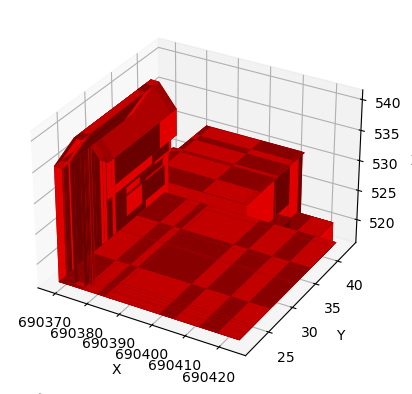

In [35]:
i = 400
plot_building_surfaces(buildings[i:i+1])

In [ ]:
import matplotlib.pyplot as plt
plot_building_surfaces(buildings[0])